In [1]:
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
from pandas.io.json import json_normalize    
import re
import seaborn as sns

Parsing functionality for event types:
```
{'CommitCommentEvent',
 'CreateEvent',
 'DeleteEvent',
 'ForkEvent',
 'GollumEvent',
 'IssueCommentEvent',
 'IssuesEvent',
 'MemberEvent',
 'PublicEvent',
 'PullRequestEvent',
 'PullRequestReviewCommentEvent',
 'PushEvent',
 'ReleaseEvent',
 'WatchEvent'}
 ```

In [2]:
ALL_EVENTS = {
    '<START>',
    'CommitCommentEvent',
    'CreateEvent',
    'DeleteEvent',
    'ForkEvent',
    'GollumEvent',
    'IssueCommentEvent',
    'IssuesEvent',
    'MemberEvent',
    'PublicEvent',
    'PullRequestEvent',
    'PullRequestReviewCommentEvent',
    'PushEvent',
    'ReleaseEvent',
    'WatchEvent',
    '<END>'
}

In [3]:
def is_event(record, e):
    return record['type'] == e

In [4]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def preprocess_message(m):
    m = m.lower()
    m = strip_html(m)
    m = remove_between_square_brackets(m)
    return m

## Event-level analysis

In [5]:
event_sequence = defaultdict(list)
events = []
with open("../data/practice_gh.json", 'r') as f:
    for i, record in enumerate(f):
        data = json.loads(record)
        _data = {
            'idx': i,
            'repo_id': data['repo']['id'],
            'created_at': data['created_at'],
            'event_type': data['type']}
        events.append(_data)
        event_sequence[_data['repo_id']].append(_data['event_type'])

### Events transition matrix

In [6]:
sequences = [np.array(['<START>'] + s + ['<END>']) for s in event_sequence.values()]

In [7]:
sequences_flattend = np.concatenate(sequences).flatten()

In [8]:
# Bigrams
d_bigrams = defaultdict(list)
for (first, second) in list(nltk.bigrams(sequences_flattend)):
    d_bigrams[first].append(second)
d2_bigrams = defaultdict(Counter)
# Transition counts
for k, arr in d_bigrams.items():
    d2_bigrams[k] = Counter(arr)
    # Fill 0 probs
    missing_keys = ALL_EVENTS - set(d2_bigrams[k].keys())
    for missing_key in missing_keys:
        d2_bigrams[k][missing_key] = 0

In [16]:
# Note we need to sort and align keys and values here.
for k, arr in sorted(d2_bigrams.items(), key=lambda x: x[0]):
    keys, vals = zip(*sorted(arr.items(), key=lambda x: x[0]))
    assert sorted(d2_bigrams.keys()) == list(keys)
    cnts = np.fromiter(vals, dtype=float)
    total = np.sum(cnts)
    probs = cnts / total
    d2_bigrams[k] = {ks:pr for ks, pr in zip(keys, probs)}
    
for k, vs in d2_bigrams.items():
    assert((np.sum(list(vs.values()))-1) < 1e-8)

In [17]:
rows = list(sorted(d2_bigrams.keys()))

M = []
for row in rows:
    curr_d = d2_bigrams[row]
    curr_keys = []
    curr_prs = []
    for ks, vs in sorted(curr_d.items(), key=lambda x: x[0]):
        curr_keys.append(ks)
        curr_prs.append(vs)
    assert(rows == curr_keys)
    M.append(curr_prs)
M = np.array(M)
    
# M = np.array([list(d2_bigrams[row].values()) for row in rows])
assert(M.shape == (len(rows), len(rows)))

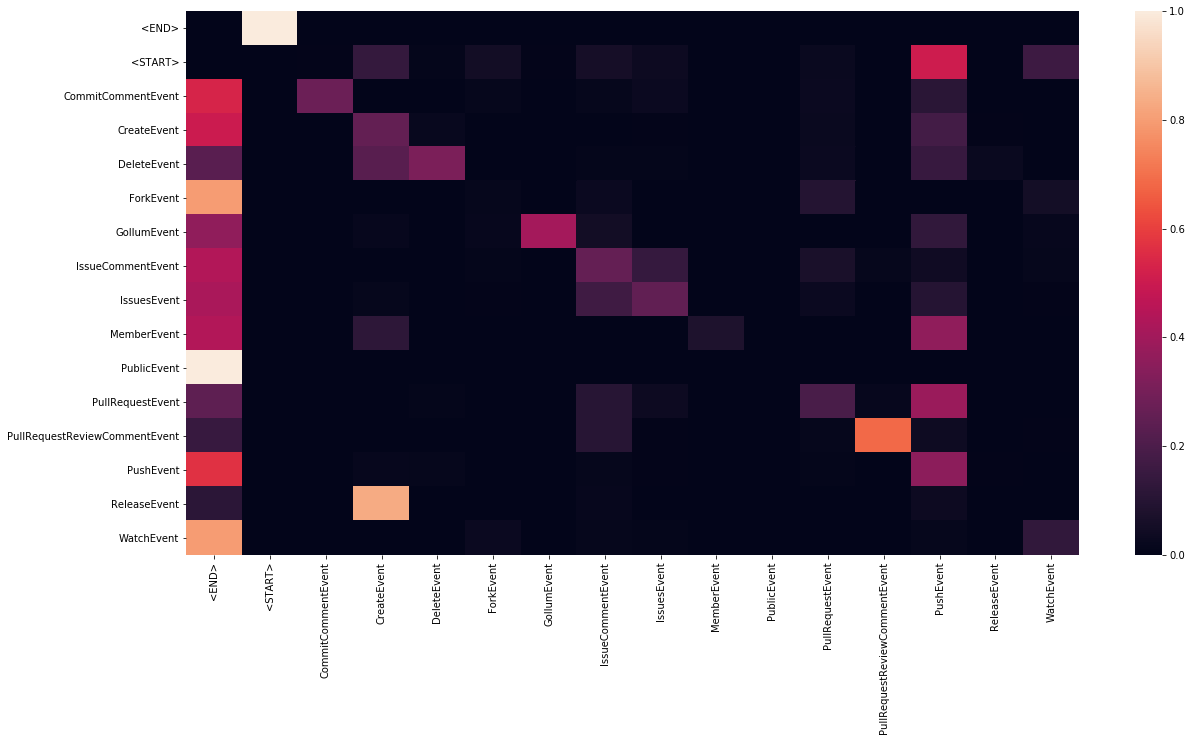

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(M, xticklabels=rows, yticklabels=rows, vmax=1.0)

### Event lengths

Events data is strongly skewed - just a few events per repo. Is this part of how the data has been sampled? Or true to the lifetimes of the repos?

In [24]:
df_events = pd.DataFrame(events)

In [31]:
df_counts = df_events \
    .groupby("repo_id") \
    .count() \
    .reset_index() \
    .sort_values('idx', ascending=False) \
    .drop(['created_at', 'event_type'], axis=1) \
    .rename(columns={'idx': 'cnt'})

In [42]:
df_counts[['cnt']].describe()

,cnt
count,6198.000000
mean,1.831397
std,2.389086
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,80.000000


In [52]:
for i in range(1, 10):
    print("Number of events in repo > {}".format(i))
    print(np.sum(df_counts['cnt'] > i) / len(df_counts))

Number of events in repo > 1
0.3360761535979348
Number of events in repo > 2
0.16505324298160698
Number of events in repo > 3
0.0866408518877057
Number of events in repo > 4
0.054049693449499836
Number of events in repo > 5
0.03646337528234914
Number of events in repo > 6
0.026944175540496936
Number of events in repo > 7
0.020813165537270088
Number of events in repo > 8
0.015166182639561149
Number of events in repo > 9
0.012100677637947725


/Users/benpeloquin/anaconda/envs/github-data/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


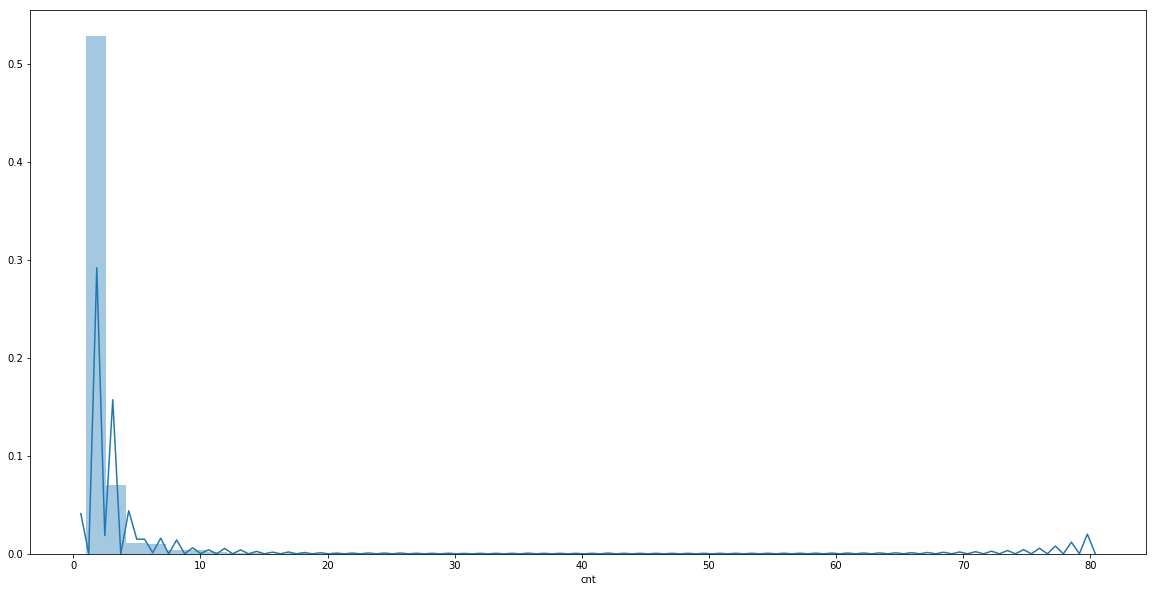

In [43]:
plt.figure(figsize=(20,10))
sns.distplot(df_counts['cnt']);

### Push Events

In [35]:
class EventParser:
    def __init__(self, data, idx):
        self.raw_data = data
        self.idx = idx
        
    def parse(self, data):
        """Extract attributes from data."""
        NotImplementedError()
        
    def to_dict(self):
        """Attributes to dict."""
        NotImplementedError()
        
class PushEventParser(EventParser):
    def __init__(self, data, idx):
        super(PushEventParser, self).__init__(data, idx)
        self.type = "PushEvent"
        
    def parse(self):
        """Extract attributes from data."""
        self.repo_id = data['repo']['id']
        self.repo_name = data['repo']['name']
        self.before = data['payload']['before']
        self.commits = data['payload']['commits']
        self.processed_commits = self._extract_commits()
        self.distinct = data['payload']['distinct_size']  # Number of commits in payload
        self.created_at = data['created_at']
        
    def to_dict(self):
        """Attributes to dict list of dicts.
        
        Note that we return list of dicts to handle payloads with lists.
        
        Expect to accumulate data in lists using .extend()
        
        """
        data = []
        d_global = {
            "repo_id": self.repo_id,
            "repo_name": self.repo_name,
            "distinct": self.distinct,
            "created_at": self.created_at
        }
        for commit in self.processed_commits:
            commit.update(d_global)
            data.append(commit)
        return data
        
    def _extract_commits(self):
        processed_commits = []
        for i, commit in enumerate(self.commits):
            curr_commmit = {
                'commit_idx': i,
                'commit_sha': commit['sha'],
                'is_unique': commit['distinct'],
                'message': commit['message']
            }
            processed_commits.append(curr_commmit)
        return processed_commits

In [37]:
d = []
with open("../data/practice_gh.json", 'r') as f:
    for i, record in enumerate(f):
        data = json.loads(record)
        if is_event(data, 'PushEvent'):
            import pdb; pdb.set_trace();
            
            parser = PushEventParser(data, i)
            parser.parse()
            curr_data = parser.to_dict()
            d.extend(curr_data)

> <ipython-input-37-b24b9e20a8f0>(8)<module>()
-> parser = PushEventParser(data, i)
(Pdb) c
> <ipython-input-37-b24b9e20a8f0>(6)<module>()
-> import pdb; pdb.set_trace();
(Pdb) c
> <ipython-input-37-b24b9e20a8f0>(8)<module>()
-> parser = PushEventParser(data, i)
(Pdb) quit()


BdbQuit: 

In [75]:
df = pd.DataFrame(d)

In [76]:
preprocess_message(df['message'][0])

'fix main header height on mobile'

In [106]:
# df.sort_values('distinct', ascending=False)
df[df['repo_id'] == 15841152].head()

,commit_idx,commit_sha,distinct,is_unique,message,repo_id,repo_name
2547,0,568cfcc7ba58e46ab8e282ba87a4fc5a01b37365,2287,True,lwt 2.4.6,15841152,pippijn/opam-repository
2548,1,af9f482a6cac522d5df6754a2186c50fba8eef2c,2287,True,tighter constraint on rss for stog 0.4 -> 0.7,15841152,pippijn/opam-repository
2549,2,a6444b805dc3489f1c08ea0aff2a02b277920633,2287,True,Merge branch 'master' of https://github.com/OC...,15841152,pippijn/opam-repository
2550,3,8a005b284fc80e5af176a8c14c77364c5b5103ce,2287,True,OCaml version specified,15841152,pippijn/opam-repository
2551,4,656fd3e9f93d8e1e4223fc225d53c478568973f3,2287,True,-j jobs option added to Coq IDE,15841152,pippijn/opam-repository


In [107]:
df.groupby(by=['repo_id']) \
    .count() \
    .reset_index(drop=False) \
    .sort_values('repo_name', ascending=False) \
    .head()

,repo_id,commit_idx,commit_sha,distinct,is_unique,message,repo_name
236,6058234,235,235,235,235,235,235
235,6058151,80,80,80,80,80,80
1012,21481110,80,80,80,80,80,80
231,6031942,80,80,80,80,80,80
1076,22131621,59,59,59,59,59,59
